In [1]:
import matplotlib.pyplot as plt
import numpy as np
import numpy.linalg as nl
import pandas as pd
import MDSplus as mds
import mst_mach_tools as mmt
from ProbeDictionaries import MachProbeDict, MachProbeDictV2

In [2]:
shot_file = "shot_log_week1_2023.xlsx"
compressed_shot_settings = pd.read_excel(shot_file, skiprows=1, header=0)
shot_settings = []
for i, shot in enumerate(compressed_shot_settings['Shots']): 
    shot=str(shot)
    if shot == 'nan':
        continue
    try:
        int(shot[0])
    except:
        continue
    if '-' not in shot:
        shot_settings.append(compressed_shot_settings.iloc[i].to_dict())
    if '-' in shot:
        shot_start, shot_end = shot.split('-')
        date = shot_start[:-3]
        start = shot_start[-3:]
        for j in range(int(start), int(shot_end) + 1):
            shot_to_save = date + str(j).zfill(3)
            settings = compressed_shot_settings.iloc[i].to_dict()
            settings['Shots'] = int(shot_to_save)
            shot_settings.append(settings)
shot_settings = pd.DataFrame(shot_settings)

In [4]:
shotlist=shot_settings['Shots'][(shot_settings['x from wall (cm)']==8.0)].values #[(shot_settings['B3.3']==186)]#[(shot_settings['x from wall (cm)']==4.0)]

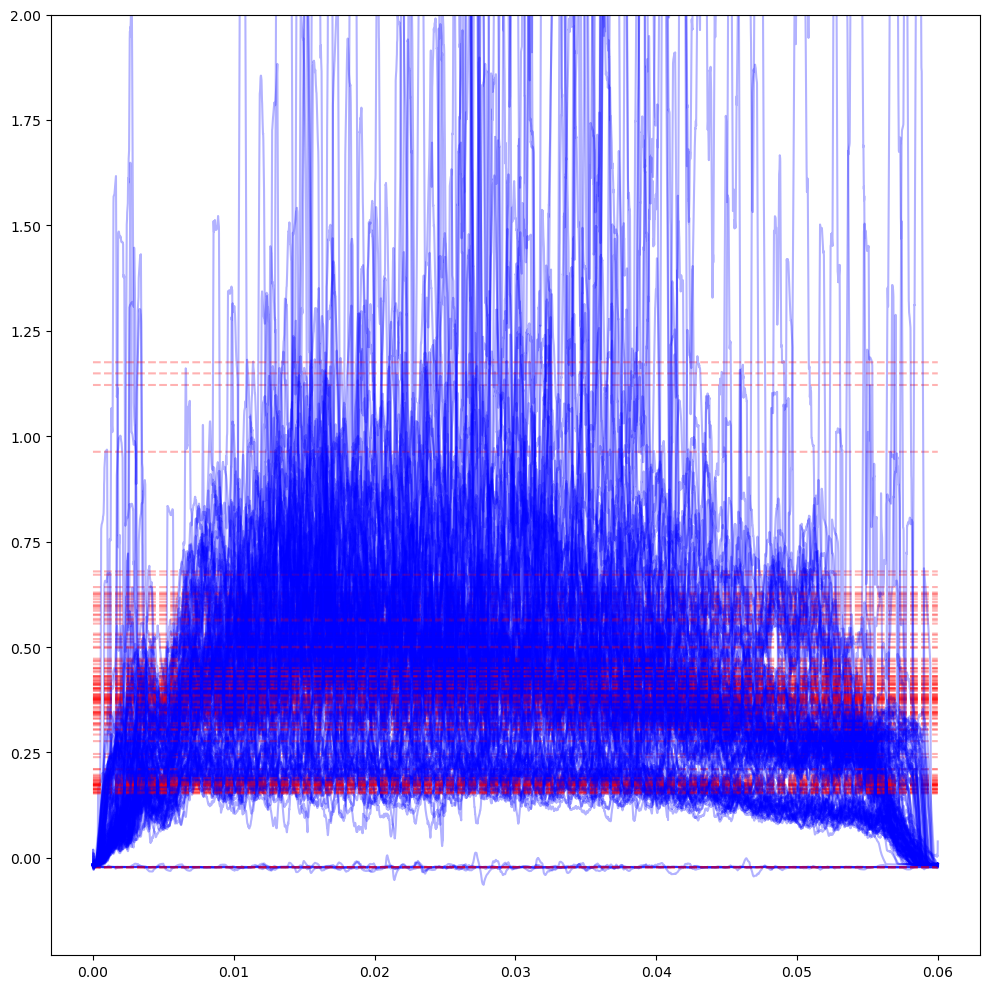

In [4]:
I_sat={}
fig1,ax1=plt.subplots(1,1,sharey=True,sharex=True,figsize=(10,10))

Plot=True
Probes=['33'] #MachProbeDict.keys()
comp='toni'
tmin=0.000
tmax=0.060
n0=1231024009
n=1231024029

for p in Probes:
    I_sat[p]=[]
    for i in shotlist: #range(n0,n):
        x,y = mmt.get_data(name=MachProbeDict[p]['ProbeName'],shot=i,tree='mst',comp=comp,tmin=tmin,tmax=tmax)
        ys=mmt.smooth(y,100)
        I_sat[p].append(ys.mean())
        if Plot:
            x1 = int(p[0])-1
            y1 = int(p[1])-1
            ax1.plot(x,ys,'b',alpha=0.3)
            ax1.plot(x,ys.mean()*np.ones(len(x)),'r--',alpha=0.3)
            ax1.set_ylim(top=2.0)
                
fig1.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)

In [5]:
len(I_sat['33'])

144

In [6]:
V_bias={}
for p in Probes:
    V_bias[p]=shot_settings[MachProbeDict[p]['Bias_Voltage']][shot_settings['Shots'].isin(shotlist)].values

In [7]:
V_bias['33'].shape

(144,)

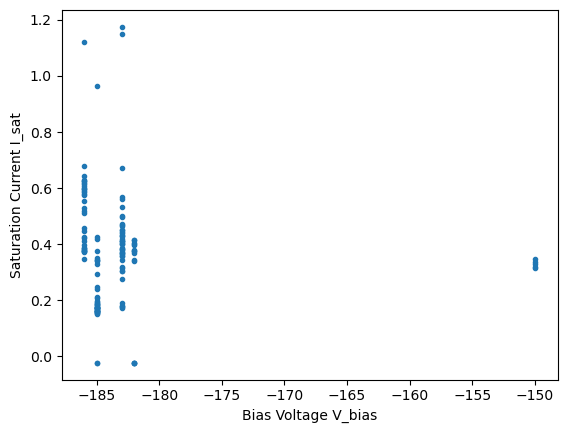

In [8]:
for p in Probes:
    plt.plot(-V_bias[p],I_sat[p],'.')
    plt.xlabel('Bias Voltage V_bias')
    plt.ylabel('Saturation Current I_sat')

In [113]:
"ORGANIZE 'shot_settings' BY PROBE DEPTH (x)"

shotlist={}
for XX in pd.Series(shot_settings['x from wall (cm)']).unique():
    shotlist[XX]=shot_settings[(shot_settings['x from wall (cm)']==XX)] #[(shot_settings['B3.3']==186)]#[(shot_settings['x from wall (cm)']==4.0)]
shotlist.keys()

dict_keys([5.0, -14.5, 4.0, 6.0, 8.0, -12.0, -10.75, 10.0])

No MDS data for shot 1231024004
No MDS data for shot 1231024004
No MDS data for shot 1231024004
No MDS data for shot 1231024004
No MDS data for shot 1231024004
No MDS data for shot 1231024004
No MDS data for shot 1231024004
No MDS data for shot 1231024004
No MDS data for shot 1231024004
No MDS data for shot 1231024004
No MDS data for shot 1231024004
No MDS data for shot 1231024004
No MDS data for shot 1231024004
No MDS data for shot 1231024004
No MDS data for shot 1231024004
No MDS data for shot 1231024004


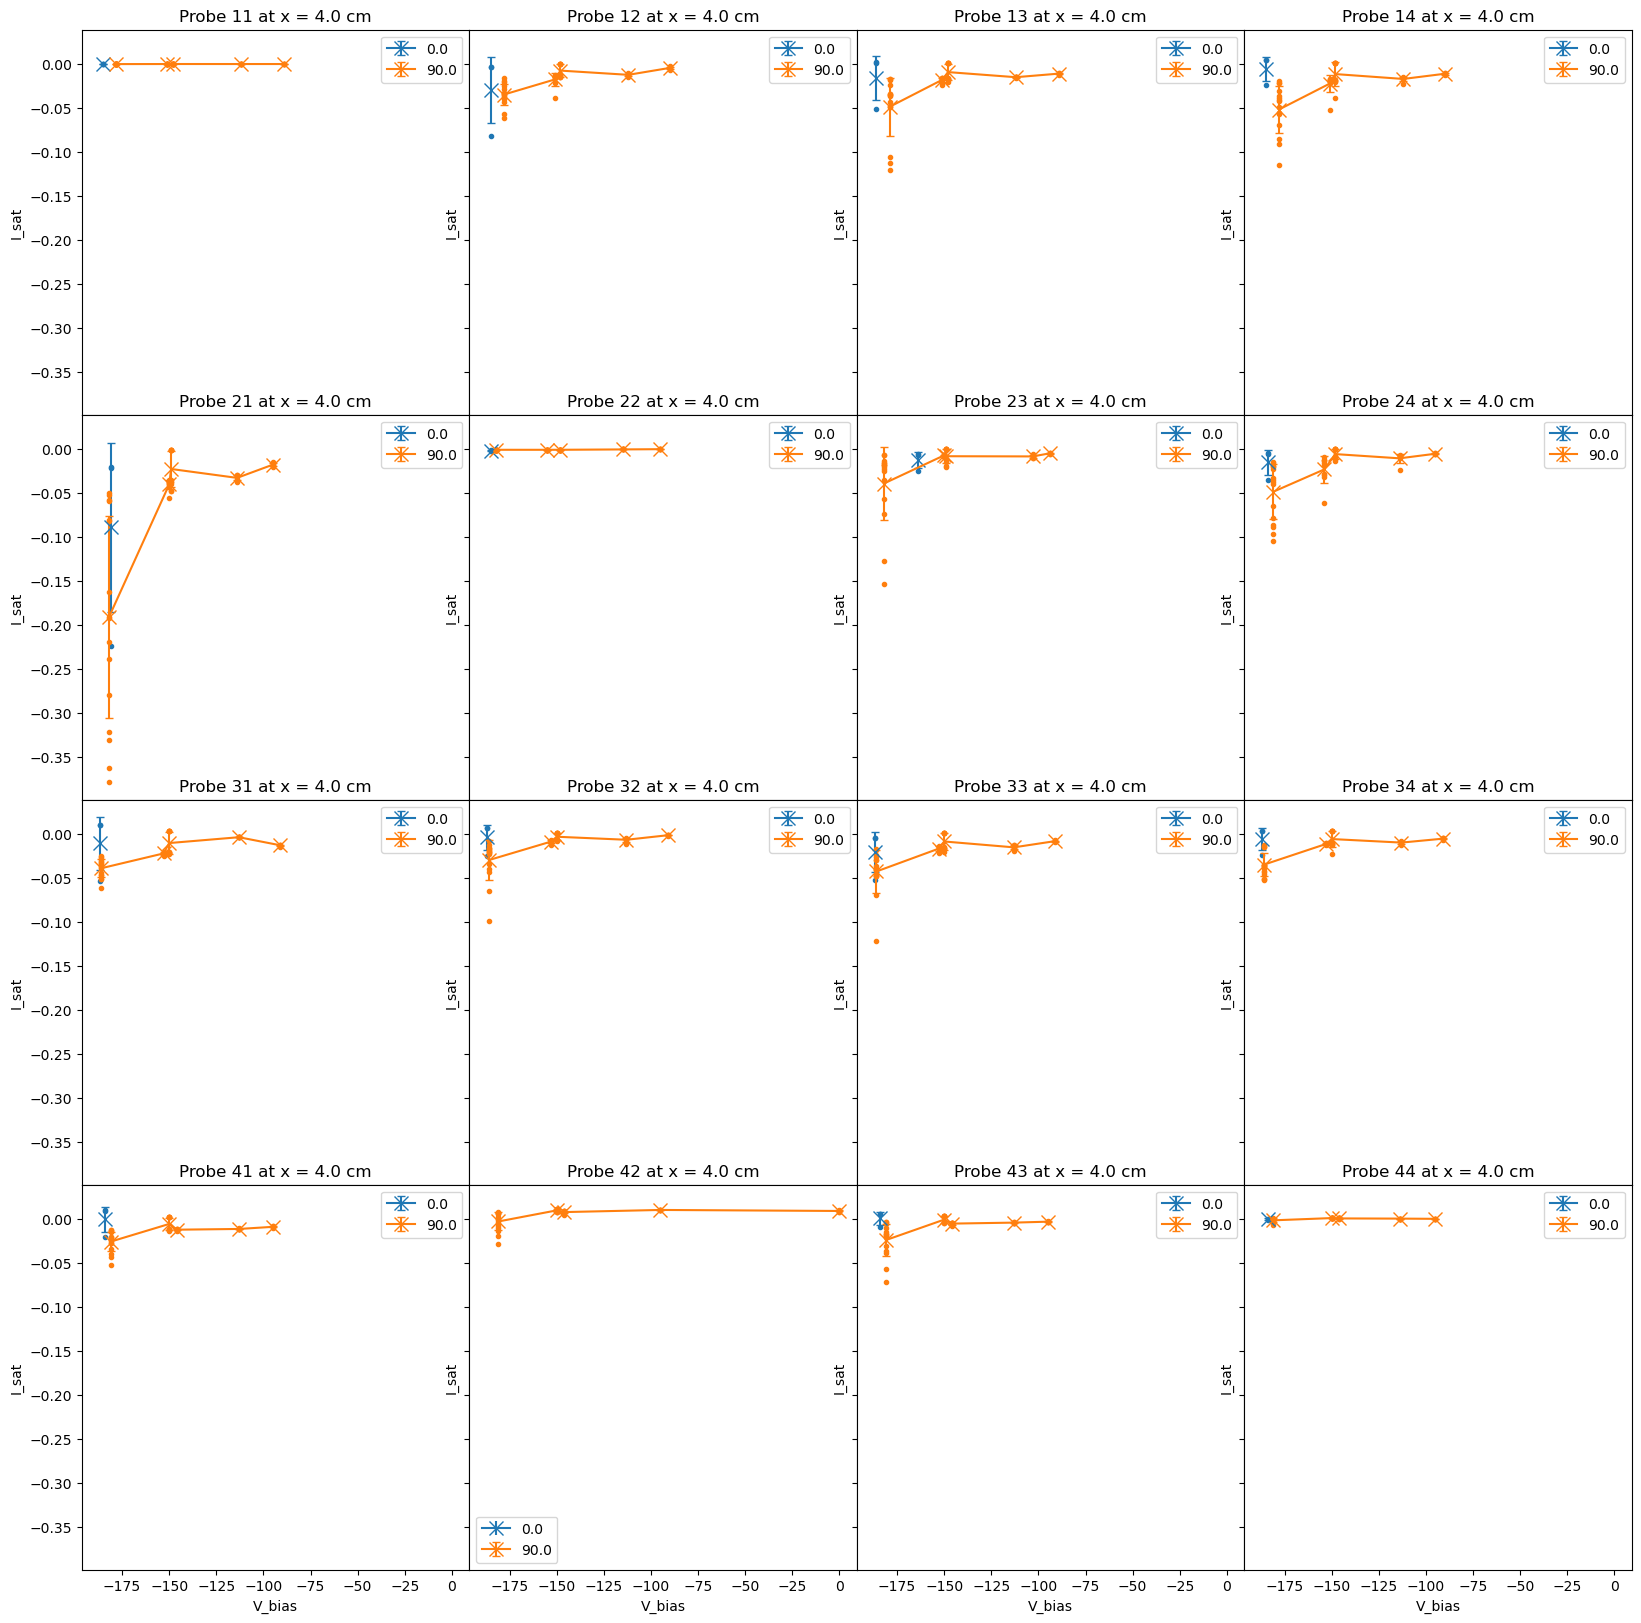

In [112]:
"MAIN I-V CLOUD PLOTTING SCRIPT"

I_sat={}
V_bias={}
fig1,ax1=plt.subplots(4,4,sharey=True,sharex=True,figsize=(20,20))

Plot=True
Probes=MachProbeDict.keys()
Depth=4.0
comp='toni'
tmin=0.000
tmax=0.060


            
for n,p in enumerate(Probes):
    Color=iter(plt.rcParams['axes.prop_cycle'])
    AA=np.sort(shotlist[Depth].Orientation.unique())

    for aa in AA:
        C=next(Color)
        V_bias[p]=[]
        I_sat[p]=[]
    
        for i in shotlist[Depth]['Shots'][(shotlist[Depth]['Orientation']==aa)].values:
            if i < 1231025028:
                MPD = MachProbeDict
            else:
                MPD = MachProbeDictV2
            
            try:
                x,y = mmt.get_data(name=MPD[p]['ProbeName'],shot=i,tree='mst',comp=comp,tmin=tmin,tmax=tmax)
            except:
                print("No MDS data for shot {}".format(i))
                continue 
            ys=mmt.smooth(y,100)
            
            RJ=MPD[p]['Resistance']
            if shotlist[Depth][RJ][(shotlist[Depth]['Shots']==i)].values[0]=='N.C.':
                continue
            elif np.isnan(shotlist[Depth][RJ][(shotlist[Depth]['Shots']==i)].values[0]):
                continue
            else:
                I_sat[p].append(-ys.mean()/shotlist[Depth][RJ][(shotlist[Depth]['Shots']==i)].values[0])
            
                BV=MPD[p]['Bias_Voltage']
                V_bias[p].append(-shotlist[Depth][BV][(shotlist[Depth]['Shots']==i)].values[0])
        
        ax1.flat[n].plot(V_bias[p],I_sat[p],'.',c=C['color'])
        
        IV=list(zip(V_bias[p],I_sat[p]))
        V_series=np.unique(V_bias[p])
        I_series=[np.mean([ii for (vv,ii) in IV if vv == v]) for v in V_series]
        I_std=[np.std([ii for (vv,ii) in IV if vv == v]) for v in V_series]
        
        ax1.flat[n].errorbar(V_series,I_series,yerr=I_std,fmt='x-',label=aa,c=C['color'],markersize=10,capsize=3)

    ax1.flat[n].legend()
    ax1.flat[n].set_xlabel('V_bias')
    ax1.flat[n].set_ylabel('I_sat')
    ax1.flat[n].set_title('Probe {} at x = {} cm'.format(p,Depth))
    plt.subplots_adjust(wspace=0, hspace=0)

In [64]:
for B in shotlist.keys():
    VVV = np.sort(pd.Series(shotlist[B]['B3.3']).unique())
    VVV = VVV[~np.isnan(VVV)]
    print('Depth {} : Voltages {}'.format(B,str(VVV)))

Depth 5.0 : Voltages [100.]
Depth -14.5 : Voltages [0.]
Depth 4.0 : Voltages [ 91. 113. 150. 153. 186. 187.]
Depth 6.0 : Voltages [186. 187.]
Depth 8.0 : Voltages [150. 182. 183. 185. 186.]
Depth -12.0 : Voltages [0.]
Depth -10.75 : Voltages []
Depth 10.0 : Voltages [183.]


In [28]:
Color=iter(plt.rcParams['axes.prop_cycle'])
C=next(Color)
C['color']

'#1f77b4'

In [58]:
A=[3,3,4,3,5,5,6,7,8]
B=[2,1,4,6,7,9,0,3,4]
D=list(set(A))
C=list(zip(A,B))
[np.mean([j for (i,j) in C if i == x]) for x in D]

[3.0, 4.0, 8.0, 0.0, 3.0, 4.0]